In [1]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
import numpy as np
import joblib

In [2]:
#Loading training and testing set

feature_data_train = pd.read_csv("C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Ecoli_data\\Training\\MLP\\MLP_feature_training.csv", header = 0)
solubility_data_train = pd.read_csv("C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Ecoli_data\\Training\\MLP\\solubility_training.csv", header = 0)


In [3]:
#Preprocessing: dropping unnecessary columns
train_index = feature_data_train['Number']
feature_data_train = feature_data_train.drop(['Number', 'FASTA', 'gene','calculated pI'], axis=1)
solubility_data_train = solubility_data_train.drop(['Number'],axis=1)

test_index = feature_data_test['Number']
feature_data_test = feature_data_test.drop(['Number', 'FASTA', 'gene','calculated pI'], axis=1)
solubility_data_test = solubility_data_test.drop(['Number'],axis=1)

In [4]:
scaler_mean = feature_data_train.mean()
scaler_std = feature_data_train.std()

mean_list=[]
std_list=[]

for i in range(len(scaler_mean)):
    mean_list.append(scaler_mean[i])
    std_list.append(scaler_std[i])

mean = np.array(mean_list)
std = np.array(std_list)


np.save("C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Ecoli_data\\Scaling\\MLP\\mean.npy",mean)
np.save("C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Ecoli_data\\Scaling\\MLP\\std.npy",std)

In [6]:
#Scaling, defining input and target data for modeling
inputs_train = (feature_data_train.values - mean)/std
target_train = solubility_data_train

inputs_test = (feature_data_test.values - mean)/std
target_test = solubility_data_test

target_train = target_train.to_numpy()
target_test = target_test.to_numpy()

In [15]:
#defining metrics
#base code retrived from  J Cheminform 13, 7 (2021). https://doi.org/10.1186/s13321-021-00488-1

def analysis(y_true, y_pred):
    binary_pred = [1 if pred >= 0.5 else 0 for pred in y_pred]
    binary_true = [1 if true >= 0.5 else 0 for true in y_true]

    # continous evaluate
    r2 = metrics.r2_score(y_true, y_pred)
    rmse = (mean_squared_error(y_true,y_pred))
    
    
    
    # binary evaluate
    binary_acc = metrics.accuracy_score(binary_true, binary_pred)
    precision = metrics.precision_score(binary_true, binary_pred)
    recall = metrics.recall_score(binary_true, binary_pred)
    f1 = metrics.f1_score(binary_true, binary_pred)
    auc = metrics.roc_auc_score(binary_true, y_pred)
    mcc = metrics.matthews_corrcoef(binary_true, binary_pred)
    TN, FP, FN, TP = metrics.confusion_matrix(binary_true, binary_pred).ravel()
    sensitivity = 1.0 * TP / (TP + FN)
    specificity = 1.0 * TN / (FP + TN)

    result = {
        'r2': r2,
        'rmse': rmse**(1/2),
        'binary_acc': binary_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'mcc': mcc,
        'sensitivity': sensitivity,
        'specificity': specificity,
    }
    return result

In [16]:
#Support vector regressor
svr_reg = SVR(kernel = "rbf",gamma=0.1, C=0.05) #"rbf"
svr_reg.fit(inputs_train, np.ravel(target_train,order='C'))
svr_reg_train= svr_reg.predict(inputs_train)
svr_reg_test= svr_reg.predict(inputs_test)



filename = 'C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Models\\SVR.sav'
joblib.dump(svr_reg, filename)


#analysis(target_train, svr_reg_train)
analysis(target_test, svr_reg_test)

{'r2': 0.4306789262251819,
 'rmse': 0.2464563514948995,
 'binary_acc': 0.7838926174496644,
 'precision': 0.7544910179640718,
 'recall': 0.7613293051359517,
 'f1': 0.7578947368421053,
 'auc': 0.8470890435950202,
 'mcc': 0.5627690737636647,
 'sensitivity': 0.7613293051359517,
 'specificity': 0.8019323671497585}

In [11]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(inputs_train,np.ravel(target_train))
reg_train = reg.predict(inputs_train)
reg_test = reg.predict(inputs_test)


In [12]:
df = pd.DataFrame(reg_test)
merge3 = [test_index, df]
MLR_test_result = pd.concat(merge3, axis=1)
MLR_test_result.to_csv("C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Ecoli_data\\MLR_result.csv")

In [17]:
#KNN
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors=16)
knn_reg.fit(inputs_train, np.ravel(target_train))
knn_reg_train= knn_reg.predict(inputs_train)
knn_reg_test= knn_reg.predict(inputs_test)

filename = 'C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Models\\KNN.sav'
joblib.dump(knn_reg, filename)

#analysis(target_train, knn_reg_train)
analysis(target_test, knn_reg_test)

{'r2': 0.3957368572325455,
 'rmse': 0.2539068617055099,
 'binary_acc': 0.7610738255033557,
 'precision': 0.7459807073954984,
 'recall': 0.7009063444108762,
 'f1': 0.7227414330218068,
 'auc': 0.8325415590291461,
 'mcc': 0.513962858547476,
 'sensitivity': 0.7009063444108762,
 'specificity': 0.8091787439613527}

In [18]:
#Decision tree regressor #bad result
from sklearn.tree import DecisionTreeRegressor

DT_reg = DecisionTreeRegressor(random_state=150)
DT_reg.fit(inputs_train, np.ravel(target_train))
DT_reg_train= DT_reg.predict(inputs_train)
DT_reg_test= DT_reg.predict(inputs_test)



#filename = 'C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Models\\KNN.sav'
#joblib.dump(knn_reg, filename)


#analysis(target_train, DT_reg_train)
analysis(target_test, DT_reg_test)

{'r2': -0.1554544570808607,
 'rmse': 0.3511056362196923,
 'binary_acc': 0.676510067114094,
 'precision': 0.6229508196721312,
 'recall': 0.6888217522658611,
 'f1': 0.654232424677188,
 'auc': 0.7200840667279654,
 'mcc': 0.3533291565310353,
 'sensitivity': 0.6888217522658611,
 'specificity': 0.6666666666666666}

In [19]:
#SGD regressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline

SGD_reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-1))
SGD_reg.fit(inputs_train, np.ravel(target_train))
SGD_reg_train= SGD_reg.predict(inputs_train)
SGD_reg_test= SGD_reg.predict(inputs_test)




filename = 'C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Models\\SGD.sav'
joblib.dump(SGD_reg, filename)


#analysis(target_train, SGD_reg_train)
analysis(target_test, SGD_reg_test)

{'r2': 0.3563360691664824,
 'rmse': 0.2620541076818852,
 'binary_acc': 0.7355704697986577,
 'precision': 0.6801075268817204,
 'recall': 0.7643504531722054,
 'f1': 0.7197724039829303,
 'auc': 0.8236058204533182,
 'mcc': 0.4739423036730738,
 'sensitivity': 0.7643504531722054,
 'specificity': 0.7125603864734299}

In [20]:
#Lasso regressor bad result
from sklearn import linear_model


LS_reg = linear_model.Lasso(alpha=1)
LS_reg.fit(inputs_train, np.ravel(target_train))
LS_reg_train= LS_reg.predict(inputs_train)
LS_reg_test= LS_reg.predict(inputs_test)




#filename = 'C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Models\\SGD.sav'
#joblib.dump(SGD_reg, filename)


#analysis(target_train, SGD_reg_train)
analysis(target_test, LS_reg_test)

C:\Users\johnkwon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'r2': -3.330148038882541e-06,
 'rmse': 0.3266345406429276,
 'binary_acc': 0.5557046979865772,
 'precision': 0.0,
 'recall': 0.0,
 'f1': 0.0,
 'auc': 0.5,
 'mcc': 0.0,
 'sensitivity': 0.0,
 'specificity': 1.0}

In [21]:
#PLSRegression

from sklearn.cross_decomposition import PLSRegression
pls_reg = PLSRegression(n_components=20)


pls_reg.fit(inputs_train, np.ravel(target_train))
pls_reg_train= pls_reg.predict(inputs_train)
pls_reg_test= pls_reg.predict(inputs_test)

filename = 'C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Models\\PLS.sav'
joblib.dump(pls_reg, filename)

#analysis(target_train, pls_reg_train)
analysis(target_test, pls_reg_test)

{'r2': 0.3649552589669701,
 'rmse': 0.26029363417896845,
 'binary_acc': 0.7355704697986577,
 'precision': 0.6781914893617021,
 'recall': 0.770392749244713,
 'f1': 0.7213578500707214,
 'auc': 0.8278237517696339,
 'mcc': 0.4751666889407393,
 'sensitivity': 0.770392749244713,
 'specificity': 0.7077294685990339}

Epoch 1/21
70/70 [==============================] - 1s 1ms/step - loss: 0.0709 - mae: 0.2219 - mse: 0.0709
Epoch 2/21
70/70 [==============================] - 0s 990us/step - loss: 0.0602 - mae: 0.2003 - mse: 0.0602
Epoch 3/21
70/70 [==============================] - 0s 1ms/step - loss: 0.0584 - mae: 0.1961 - mse: 0.0584
Epoch 4/21
70/70 [==============================] - 0s 1ms/step - loss: 0.0572 - mae: 0.1932 - mse: 0.0572
Epoch 5/21
70/70 [==============================] - 0s 1ms/step - loss: 0.0563 - mae: 0.1899 - mse: 0.0563
Epoch 6/21
70/70 [==============================] - 0s 1ms/step - loss: 0.0559 - mae: 0.1909 - mse: 0.0559
Epoch 7/21
70/70 [==============================] - 0s 1ms/step - loss: 0.0558 - mae: 0.1904 - mse: 0.0558
Epoch 8/21
70/70 [==============================] - 0s 1ms/step - loss: 0.0548 - mae: 0.1884 - mse: 0.0548
Epoch 9/21
70/70 [==============================] - 0s 1ms/step - loss: 0.0536 - mae: 0.1850 - mse: 0.0536
Epoch 10/21
70/70 [================

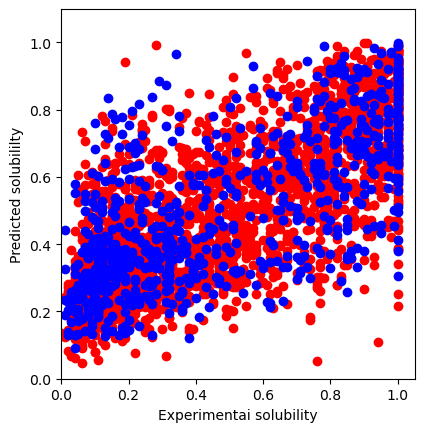

{'r2': 0.45565317612952205,
 'rmse': 0.15607197084837598,
 'binary_acc': 0.7788203753351206,
 'precision': 0.7406340057636888,
 'recall': 0.7740963855421686,
 'f1': 0.7569955817378498,
 'auc': 0.8547086898317909,
 'mcc': 0.5546809011128739,
 'sensitivity': 0.7740963855421686,
 'specificity': 0.782608695652174}

In [28]:
#MLP model
model=Sequential()
model.add(Dense(128,input_dim=21,activation='LeakyReLU'))
model.add(Dropout(0.2))
BatchNormalization()
model.add(Dense(64,activation='LeakyReLU'))
BatchNormalization(),
model.add(Dense(32,activation='LeakyReLU'))
BatchNormalization(),
#model.add(Dense(1,activation='LeakyReLU'))
model.add(Dense(1,activation='sigmoid'))
#model.add(Dense(1,activation='ReLU'))
model.compile(loss='mse', optimizer='Adamax', metrics=['mae','mse'])    
model.fit(inputs_train, target_train, epochs = 21)
    
    
train_predictions=model.predict(inputs_train).flatten()
test_predictions = model.predict(inputs_test).flatten()
train_labels=target_train
test_labels=target_test

plt.scatter(train_labels,train_predictions,color='red')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.scatter(test_labels, test_predictions,color='blue')
plt.xlabel('Experimentai solubility')
plt.ylabel('Predicted solubililty')
plt.axis('equal')
plt.axis('square')
    
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
    #_ = plt.plot([-100, 100], [-100, 100])
plt.show()

    
analysis(train_labels, train_predictions)
analysis(test_labels, test_predictions)


In [29]:
analysis(train_labels, train_predictions)

{'r2': 0.5228940406084315,
 'rmse': 0.15151638615907273,
 'binary_acc': 0.7921323200715243,
 'precision': 0.7721393034825871,
 'recall': 0.766798418972332,
 'f1': 0.7694595934556271,
 'auc': 0.8718173751714124,
 'mcc': 0.5802201406330789,
 'sensitivity': 0.766798418972332,
 'specificity': 0.8130612244897959}

In [25]:
model.save('C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Models\\MPL.h5')

In [8]:
model=load_model('C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Models\\MPL.h5')

In [11]:
MLP_train_result = model.predict(inputs_train)
MLP_test_result= model.predict(inputs_test)


df_MLP_train =  pd.DataFrame(MLP_train_result)
df_MLP_test = pd.DataFrame(MLP_test_result)

24/24 [==============================] - 0s 738us/step


In [31]:
merge1 = [train_index, df_MLP_train]
MLP_train_result = pd.concat(merge1, axis=1)

merge2 = [test_index, df_MLP_test]
MLP_test_result = pd.concat(merge2, axis=1)

In [33]:
MLP_train_result.to_csv("C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Ecoli_data\\Training\\Stacking\\MLP_training.csv")
MLP_test_result.to_csv("C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Ecoli_data\\Testing\\Stacking\\MLP_testing.csv")